# ELG Signal-to-Noise Calculations

This notebook provides a standardized calculation of the DESI emission-line galaxy (ELG) signal-to-noise (SNR) figure of merit, for tracking changes to simulation inputs and models.  See the accompanying technical note [DESI-3977](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=3977) for details.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table
import astropy.cosmology
import astropy.io.fits as fits
import astropy.units as u

Parts of this notebook assume that the [desimodel package](https://github.com/desihub/desimodel) is installed (both its git and svn components) and its `data/` directory is accessible via the `$DESIMODEL` environment variable:

In [3]:
import os.path
assert 'DESIMODEL' in os.environ
assert os.path.exists(os.path.join(os.getenv('DESIMODEL'), 'data', 'spectra', 'spec-sky.dat'))

Document relevant version numbers:

In [4]:
import desimodel
import specsim

In [5]:
print(f'Using desimodel {desimodel.__version__}, specsim {specsim.__version__}')

Using desimodel 0.9.6.dev431, specsim 0.11


## ELG Spectrum

All peaks are assumed to have the same log-normal rest lineshape specified by a velocity dispersion $\sigma_v$, total flux $F_0$ and central wavelength $\lambda_0$ as:
$$
f(\lambda; F_0, \lambda_0) = \frac{F_0}{\sqrt{2\pi}\,\lambda\,\sigma_{\log}}\, \exp\left[
-\frac{1}{2}\left( \frac{\log_{10}\lambda - \log_{10}\lambda_0}{\sigma_{\log}}\right)^2\right]\; ,
$$
where
$$
\sigma_{\log} \equiv \frac{\sigma_v}{c \log 10} \; .
$$

We use the pretabulated spectrum in `$DESIMODEL/data/spectra/spec-elg-o2flux-8e-17-average-line-ratios.dat` described in Section 2.3 of DESI-867-v1,
which consists of only the following emission lines:
 - \[OII](3727A) and \[OII](3730A)
 - H-beta
 - \[OIII](4960A) and \[OIII](5008A)
 - H-alpha

Note that H-alpha is never observable for $z > 0.5$, as is always the case for DESI ELG targets.
Continuum is omitted since we are primarily interested in how well the \[OII] doublet can be identified and measured.
All lines are assumed to have the same velocity dispersion of 70 km/s.

In [6]:
elg_spec = astropy.table.Table.read(
    os.path.join(os.environ['DESIMODEL'], 'data', 'spectra', 'spec-elg-o2flux-8e-17-average-line-ratios.dat'),
    format='ascii')
elg_wlen0 = elg_spec['col1'].data
elg_flux0 = 1e-17 * elg_spec['col2'].data

## DESI ELG Sample

Look up the expected redshift distribution of DESI ELG targets from `$DESIMODEL/data/targets/nz_elg.dat`.  Note that the [OII] doublet falls off the spectrograph around z = 1.63.

In [7]:
def get_elg_nz():
    # Read the nz file from $DESIMODEL.
    full_name = os.path.join(os.environ['DESIMODEL'], 'data', 'targets', 'nz_elg.dat')
    table = astropy.table.Table.read(full_name, format='ascii')

    # Extract the n(z) histogram into numpy arrays.
    z_lo, z_hi = table['col1'], table['col2']
    assert np.all(z_hi[:-1] == z_lo[1:])
    z_edge = np.hstack((z_lo, [z_hi[-1]]))
    nz = table['col3']
    
    # Trim to bins where n(z) > 0.
    non_zero = np.where(nz > 0)[0]
    lo, hi = non_zero[0], non_zero[-1] + 1
    nz = nz[lo: hi]
    z_edge = z_edge[lo: hi + 1]
    
    return nz, z_edge

In [8]:
elg_nz, elg_z_edge = get_elg_nz()

Calculate n(z) weights corresponding to an array of ELG redshifts:

In [9]:
def get_nz_weight(z):
    """Calculate n(z) weights corresponding to input z values.
    """
    nz = np.zeros_like(z)
    idx = np.digitize(z, elg_z_edge)
    sel = (idx > 0) & (idx <= len(elg_nz))
    nz[sel] = elg_nz[idx[sel] - 1]
    return nz

Sample random redshifts from n(z):

Mean ELG redshift is 1.003


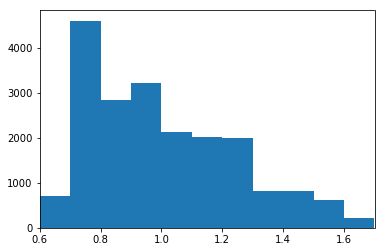

In [10]:
def generate_elg_z(n=100, seed=123):
    cdf = np.cumsum(elg_nz)
    cdf = np.hstack(([0], cdf / cdf[-1]))
    gen = np.random.RandomState(seed)
    return np.interp(gen.rand(n), cdf, elg_z_edge)
    
z=generate_elg_z(n=20000)
plt.hist(z, bins=elg_z_edge, histtype='stepfilled')
plt.xlim(elg_z_edge[0], elg_z_edge[-1])
print(f'Mean ELG redshift is {np.mean(z):.3f}')

Define a background cosmology for the angular-diameter distance used to scale galaxy angular sizes:

In [11]:
LCDM = astropy.cosmology.Planck15

Generate random ELG profiles for each target. The mean half-light radius is 0.45" and scales with redshift.

In [12]:
def generate_elg_profiles(z, seed=123, verbose=False):
    """ELG profiles are assumed to be disk (Sersic n=1) only.
    """
    gen = np.random.RandomState(seed)
    nsrc = len(z)
    source_fraction = np.zeros((nsrc, 2))
    source_half_light_radius = np.zeros((nsrc, 2))
    source_minor_major_axis_ratio = np.zeros((nsrc, 2))
    source_position_angle = 360. * gen.normal(size=(nsrc, 2))
    # Precompute cosmology scale factors.
    angscale = (
        LCDM.angular_diameter_distance(1.0) /
        LCDM.angular_diameter_distance(z)).to(1).value
    if verbose:
        print(f'mean n(z) DA(1.0)/DA(z) = {np.mean(angscale):.3f}')
    # Disk only with random size and ellipticity.
    source_fraction[:, 0] = 1.
    source_half_light_radius[:, 0] = 0.427 * np.exp(0.25 * gen.normal(size=nsrc)) * angscale
    source_minor_major_axis_ratio[:, 0] = np.minimum(0.99, 0.50 * np.exp(0.15 * gen.normal(size=nsrc)))
    if verbose:
        print(f'mean HLR = {np.mean(source_half_light_radius[:, 0]):.3f}"')
    return dict(
        source_fraction=source_fraction,
        source_half_light_radius=source_half_light_radius,
        source_minor_major_axis_ratio=source_minor_major_axis_ratio,
        source_position_angle=source_position_angle)

Diagnostic plot showing the assumed ELG population (Figure 1 of DESI-3977):

mean n(z) DA(1.0)/DA(z) = 1.021
mean HLR = 0.450"


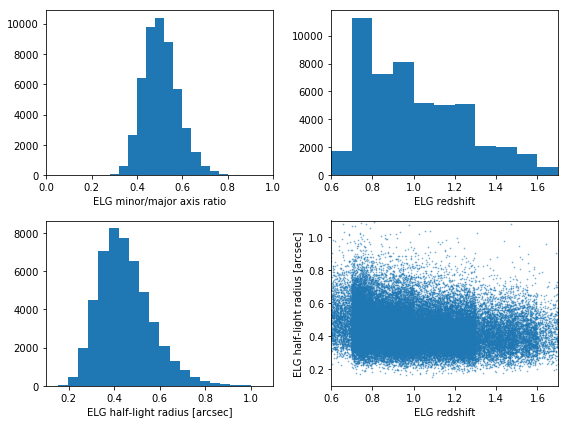

In [13]:
def plot_elg_profiles(save=None):
    z = generate_elg_z(50000)
    sources = generate_elg_profiles(z, verbose=True)
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    ax = ax.flatten()
    ax[0].hist(sources['source_minor_major_axis_ratio'][:, 0], range=(0,1), bins=25)
    ax[0].set_xlabel('ELG minor/major axis ratio')
    ax[0].set_xlim(0, 1)
    ax[1].hist(z, bins=np.arange(0.6, 1.8, 0.1))
    ax[1].set_xlim(0.6, 1.7)
    ax[1].set_xlabel('ELG redshift')
    ax[2].hist(sources['source_half_light_radius'][:, 0], bins=25)
    ax[2].set_xlabel('ELG half-light radius [arcsec]')
    ax[2].set_xlim(0.1, 1.1)
    ax[3].scatter(z, sources['source_half_light_radius'][:, 0], s=0.5, alpha=0.5)
    ax[3].set_xlabel('ELG redshift')
    ax[3].set_ylabel('ELG half-light radius [arcsec]')
    ax[3].set_xlim(0.6, 1.7)
    ax[3].set_ylim(0.1, 1.1)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_elg_profiles(save='elg-sample.png')

## Simulated SNR

Given an initialized simulator object, step through different redshifts and calculate the SNR recorded by all fibers for a fixed ELG spectrum. Save the results to a FITS file that can be used by `plot_elg_snr()`.

In [14]:
def calculate_elg_snr(simulator, save, description,
                      z1=0.6, z2=1.65, dz=0.002, zref=1.20,
                      seed=123, wlen=elg_wlen0, flux=elg_flux0):
    """Calculate the ELG [OII] SNR as a function of redshift.
    
    Parameters
    ----------
    simulator : specsim.simulator.Simulator
        Instance of an initialized Simulator object to use. Each fiber will
        be simulated independently to study variations across the focal plane.
    save : str
        Filename to use for saving FITS results.
    description : str
        Short description for the saved file header, also used for plots later.
    z1 : float
        Minimum ELG redshift to calculate.
    z2 : float
        Maximum ELG redshift to calculate.
    dz : float
        Spacing of equally spaced grid to cover [z1, z2]. z2 will be increased
        by up to dz if necessary.
    zref : float
        Reference redshift used to save signal, noise and fiberloss. Must be
        on the grid specified by (z1, z2, dz).
    seed : int or None
        Random seed used to generate fiber positions and galaxy profiles.
    wlen : array
        1D array of N rest wavelengths in Angstroms.
    flux : array
        1D array of N corresponding rest fluxes in erg / (s cm2 Angstrom).
    """
    zooms = (3715., 3742.), (4850., 4875.), (4950., 5020.)
    gen = np.random.RandomState(seed=seed)
    
    # Generate random focal plane (x,y) positions for each fiber in mm units.
    nfibers = simulator.num_fibers
    focal_r = np.sqrt(gen.uniform(size=nfibers)) * simulator.instrument.field_radius
    phi = 2 * np.pi * gen.uniform(size=nfibers)
    xy = (np.vstack([np.cos(phi), np.sin(phi)]) * focal_r).T

    # Build the grid of redshifts to simulate.
    nz = int(np.ceil((z2 - z1) / dz)) + 1
    z2 = z1 + (nz - 1) * dz
    z_grid = np.linspace(z1, z2, nz)
    iref = np.argmin(np.abs(z_grid - zref))
    assert np.abs(zref - z_grid[iref]) < 1e-5, 'zref not in z_grid'
    snr2 = np.zeros((4, nz, simulator.num_fibers))
    
    # Initialize the results.
    hdus = fits.HDUList()
    hdus.append(fits.PrimaryHDU(
        header=fits.Header({'SEED': seed, 'NFIBERS': nfibers, 'DESCRIBE': description})))
    
    # Zero-pad the input spectrum if necessary.
    wlo = 0.99 * desi.simulated['wavelength'][0] / (1 + z2)
    if wlen[0] > wlo:
        wlen = np.hstack([[wlo], wlen])
        flux = np.hstack([[0.], flux])

    # Simulate the specified rest-frame flux.
    simulator.source.update_in(
        'ELG [OII] doublet', 'elg',
        wlen * u.Angstrom, flux * u.erg/(u.s * u.cm**2 * u.Angstrom), z_in=0.)

    # Simulate each redshift.
    for i, z in enumerate(z_grid):
        # Redshift the ELG spectrum.
        simulator.source.update_out(z_out=z)
        source_flux = np.tile(simulator.source.flux_out, [nfibers, 1])
        # Generate source profiles for each target at this redshift. Since the seed is
        # fixed, only the redshift scaling of the HLR will change.
        sources = generate_elg_profiles(np.full(nfibers, z), seed=seed)
        # Simulate each source.
        simulator.simulate(source_fluxes=source_flux, focal_positions=xy, **sources)
        # Calculate the quadrature sum of SNR in each camera, by fiber.
        for output in simulator.camera_output:
            rest_wlen = output['wavelength'] / (1 + z)
            # Loop over emission lines.
            for j, (lo, hi) in enumerate(zooms):
                sel = (rest_wlen >= lo) & (rest_wlen < hi)
                if not np.any(sel):
                    continue
                # Sum SNR2 over pixels.
                pixel_snr2 = output['num_source_electrons'][sel] ** 2 / output['variance_electrons'][sel]
                snr2[j, i] += pixel_snr2.sum(axis=0)
        if i == iref:
            # Save the fiberloss fraction and total variance tabulated on the simulation grid.
            table = astropy.table.Table(meta={'ZREF': zref})
            sim = simulator.simulated
            table['WLEN'] = sim['wavelength'].data
            table['FLUX'] = sim['source_flux'].data
            table['FIBERLOSS'] = sim['fiberloss'].data
            table['NSRC'] = sim['num_source_electrons_b'] + sim['num_source_electrons_r'] + sim['num_source_electrons_z']
            table['SKYVAR'] = sim['num_sky_electrons_b'] + sim['num_sky_electrons_r'] + sim['num_sky_electrons_z']
            table['NOISEVAR'] = (
                sim['read_noise_electrons_b'] ** 2 + sim['read_noise_electrons_r'] ** 2 + sim['read_noise_electrons_z'] ** 2 +
                sim['num_dark_electrons_b'] + sim['num_dark_electrons_r'] + sim['num_dark_electrons_z'])
            hdus.append(fits.table_to_hdu(table))
            hdus[-1].name = 'REF'
    
    # Calculate the n(z) weighted mean SNR for [OII], using the median over fibers at each redshift.
    snr_oii = np.median(np.sqrt(snr2[0]), axis=-1)
    wgt = get_nz_weight(z_grid)
    snr_oii_eff = np.sum(snr_oii * wgt) / np.sum(wgt)
    print(f'n(z)-weighted effective [OII] SNR = {snr_oii_eff:.3f}')

    # Save the SNR vs redshift arrays for each emission line.
    table = astropy.table.Table(meta={'SNREFF': snr_oii_eff})
    table['Z'] = z_grid
    table['ZWGT'] = wgt
    table['SNR_OII'] = np.sqrt(snr2[0])
    table['SNR_HBETA'] = np.sqrt(snr2[1])
    table['SNR_OIII'] = np.sqrt(snr2[2])
    hdus.append(fits.table_to_hdu(table))
    hdus[-1].name = 'SNR'

    hdus.writeto(save, overwrite=True)

Calculate flux limits in bins of redshift, to compare with SRD L3.1.3:

In [26]:
def get_flux_limits(z, snr, nominal_flux=8., nominal_snr=7., ax=None):
    fluxlim = np.zeros_like(snr)
    nonzero = snr > 0
    fluxlim[nonzero] = nominal_flux * (nominal_snr / snr[nonzero])
    bins = np.linspace(0.6, 1.6, 6)
    nlim = len(bins) - 1
    medians = np.empty(nlim)
    for i in range(nlim):
        sel = (z >= bins[i]) & (z < bins[i + 1])
        medians[i] = np.median(fluxlim[sel])
    if ax is not None:
        zmid = 0.5 * (bins[1:] + bins[:-1])
        dz = 0.5 * (bins[1] - bins[0])
        ax.errorbar(zmid, medians, xerr=dz, color='b', fmt='o', zorder=10, capsize=3)
    return fluxlim, medians

Plot a summary of the results saved by `calculate_elg_snr()`. Shaded bands show the 5-95 percentile range, with the median drawn as a solid curve. The fiberloss in the lower plot is calculated at the redshift `zref` specified in `calculate_elg_snr()` (since the ELG size distribution is redshift dependent).

In [24]:
def plot_elg_snr(name, save=True):
    """Plot a summary of results saved by calculate_elg_snr().
    
    Parameters
    ----------
    name : str
        Name of the FITS file saved by calculate_elg_snr().
    """
    hdus = fits.open(name)
    hdr = hdus[0].header
    nfibers = hdr['NFIBERS']
    description = hdr['DESCRIBE']
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    plt.suptitle(description, fontsize=14)

    snr_table = astropy.table.Table.read(hdus['SNR'])
    snr_oii_eff = snr_table.meta['SNREFF']
    ref_table = astropy.table.Table.read(hdus['REF'])
    zref = ref_table.meta['ZREF']
    
    ax = axes[0]
    color = 'rgb'
    labels = '[OII]', 'H$\\beta$', '[OIII]'
    z_grid = snr_table['Z'].data
    for i, tag in enumerate(('SNR_OII', 'SNR_HBETA', 'SNR_OIII')):
        snr = snr_table[tag].data
        snr_q = np.percentile(snr, (5, 50, 95), axis=-1)
        ax.fill_between(z_grid, snr_q[0], snr_q[2], color=color[i], alpha=0.25, lw=0)
        ax.plot(z_grid, snr_q[1], c=color[i], ls='-', label=labels[i])
    ax.plot([], [], 'k:', label='n(z)')
    ax.legend(ncol=4)
    ax.set_xlabel('ELG redshift')
    ax.set_ylabel(f'Total signal-to-noise ratio')
    ax.axhline(7, c='k', ls='--')
    rhs = ax.twinx()
    rhs.plot(z_grid, snr_table['ZWGT'], 'k:')
    rhs.set_yticks([])
    ax.set_xlim(z_grid[0], z_grid[-1])
    ax.set_ylim(0, 12)
    rhs.set_ylim(0, None)
    ax.text(0.02, 0.03, f'n(z)-wgtd [OII] SNR={snr_oii_eff:.3f}',
            fontsize=12, transform=ax.transAxes)
    
    # Calculate the median [OII] flux limits.
    _, fluxlim = get_flux_limits(z_grid, np.median(snr_table['SNR_OII'], axis=-1))

    # Print latex-format results for DESI-3977 Table 2.
    print(f'&{snr_oii_eff:7.3f}', end='')
    for m in fluxlim:
        print(f' &{m:5.1f}', end='')
    print(' \\\\')

    ax = axes[1]
    wlen = ref_table['WLEN'].data
    dwlen = wlen[1] - wlen[0]
    sky_q = np.percentile(ref_table['SKYVAR'].data, (5, 50, 95), axis=-1)
    sky_q[sky_q > 0] = 1 / sky_q[sky_q > 0]
    ax.fill_between(wlen, sky_q[0], sky_q[2], color='b', alpha=0.5, lw=0)
    ax.plot([], [], 'b-', label='sky ivar')
    ax.plot(wlen, sky_q[1], 'b.', ms=0.25, alpha=0.5)
    noise_q = np.percentile(ref_table['NOISEVAR'].data, (5, 50, 95), axis=-1)
    noise_q[noise_q > 0] = 1 / noise_q[noise_q > 0]
    ax.fill_between(wlen, noise_q[0], noise_q[2], color='r', alpha=0.25, lw=0)
    ax.plot(wlen, noise_q[1], c='r', ls='-', label='noise ivar')
    floss_q = np.percentile(ref_table['FIBERLOSS'].data, (5, 50, 95), axis=-1)
    ax.plot([], [], 'k-', label='fiberloss')
    rhs = ax.twinx()
    rhs.fill_between(wlen, floss_q[0], floss_q[2], color='k', alpha=0.25, lw=0)
    rhs.plot(wlen, floss_q[1], 'k-')
    rhs.set_ylim(0.2, 0.6)
    rhs.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.1))
    rhs.set_ylabel('Fiberloss')
    ax.set_xlabel('Wavelength [A]')
    ax.set_ylabel(f'Inverse Variance / {dwlen:.1f}A')
    ax.set_xlim(wlen[0], wlen[-1])
    ax.set_ylim(0, 0.25)
    ax.legend(ncol=3)
    
    plt.subplots_adjust(wspace=0.1, top=0.95, bottom=0.05, left=0.07, right=0.95)
    
    if save:
        base, _ = os.path.splitext(name)
        plot_name = base + '.png'
        plt.savefig(plot_name)
        print(f'Saved {plot_name}')

## Examples

Demonstrate this calculation for the baseline DESI configuration with 100 fibers:

In [ ]:
import specsim.simulator

In [ ]:
desi = specsim.simulator.Simulator('desi', num_fibers=100)

**NOTE: the next cell takes about 15 minutes to run.**

In [27]:
%time calculate_elg_snr(desi, save='desimodel-0.9.6.fits', description='desimodel 0.9.6')

n(z)-weighted effective [OII] SNR = 6.764
CPU times: user 12min 31s, sys: 3min 32s, total: 16min 4s
Wall time: 16min 5s


Plot the results (Figure 2 of DESI-3977):

Saved desimodel-0.9.6.png


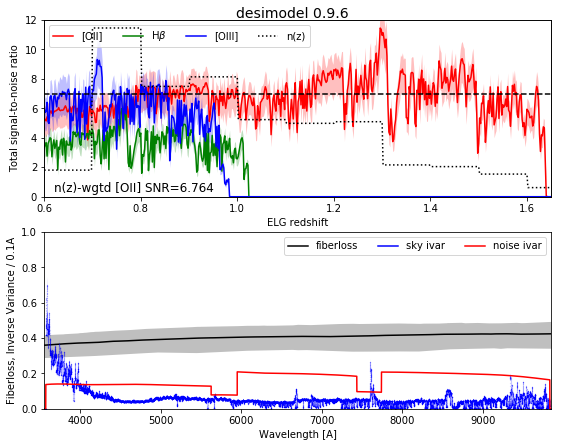

In [28]:
plot_elg_snr('desimodel-0.9.6.fits')

Check that the results with GalSim are compatible with those using the (default) fastsim mode of fiberloss calculations:

In [29]:
desi.instrument.fiberloss_method = 'galsim'

**NOTE: the next cell takes about 30 minutes to run.**

In [30]:
%time calculate_elg_snr(desi, save='desimodel-0.9.6-galsim.fits', description='desimodel 0.9.6 (galsim)')

n(z)-weighted effective [OII] SNR = 6.572
CPU times: user 25min 1s, sys: 3min 44s, total: 28min 45s
Wall time: 28min 47s


Saved desimodel-0.9.6-galsim.png


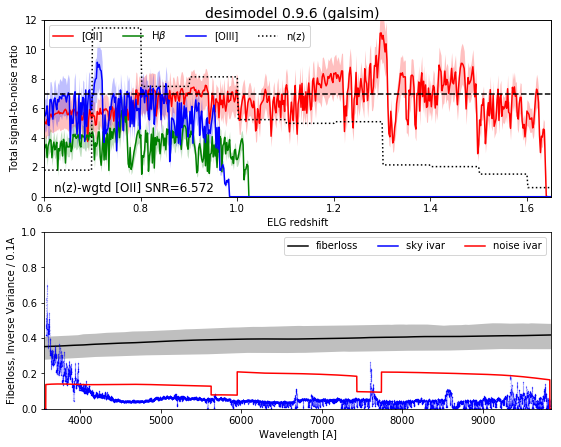

In [31]:
plot_elg_snr('desimodel-0.9.6-galsim.fits')

### CDR Comparison

Compare with the CDR forecasts based on desimodel 0.3.1 and documented in DESI-867, using data from this [FITS file](https://desi.lbl.gov/svn/docs/technotes/spectro/elg-snr/trunk/data/elg_snr2_desimodel-0-3-1.fits):

In [32]:
desi867 = astropy.table.Table.read('elg_snr2_desimodel-0-3-1.fits', hdu=1)

Check that we can reproduce the figures from DESI-867:

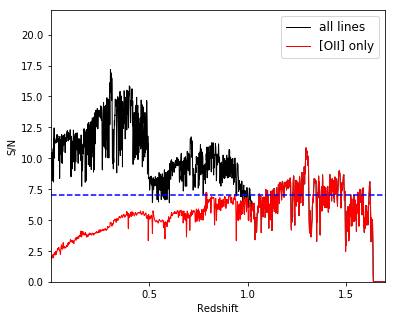

In [34]:
def desi_867_fig1():
    z = desi867['Z']
    snr_all = np.sqrt(desi867['SNR2'])
    snr_oii = np.sqrt(desi867['SNR2_OII'])
    fig = plt.figure(figsize=(6, 5))
    plt.plot(z, snr_all, 'k-', lw=1, label='all lines')
    plt.plot(z, snr_oii, 'r-', lw=1, label='[OII] only')
    plt.legend(fontsize='large')
    plt.axhline(7, c='b', ls='--')
    plt.ylim(0, 22)
    plt.xlim(z[0], z[-1])
    plt.xticks([0.5, 1.0, 1.5])
    plt.xlabel('Redshift')
    plt.ylabel('S/N')
    
desi_867_fig1()

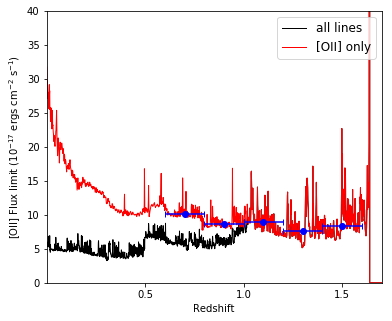

In [37]:
def desi_867_fig2():
    z = desi867['Z']
    snr_all = np.sqrt(desi867['SNR2'])
    snr_oii = np.sqrt(desi867['SNR2_OII'])
    flux_limit_all, _ = get_flux_limits(z, snr_all)
    flux_limit_oii, medians = get_flux_limits(z, snr_oii)
    fig = plt.figure(figsize=(6, 5))
    plt.plot(z, flux_limit_all, 'k-', lw=1, label='all lines')
    plt.plot(z, flux_limit_oii, 'r-', lw=1, label='[OII] only')
    plt.legend(loc='upper right', fontsize='large')
    _, _ = get_flux_limits(z, snr_oii, ax=plt.gca())
    plt.ylim(0, 40)
    plt.xlim(z[0], z[-1])
    plt.xticks([0.5, 1.0, 1.5])
    plt.xlabel('Redshift')
    plt.ylabel('[OII] Flux limit ($10^{-17}$ ergs cm$^{-2}$ s$^{-1}$)')
    
desi_867_fig2()

Print a summary for Table 2 of DESI-3977:

In [41]:
def cdr_summary():
    z = desi867['Z']
    snr_oii = np.sqrt(desi867['SNR2_OII'])
    wgt = get_nz_weight(z)
    snreff = np.sum(wgt * snr_oii) / wgt.sum()
    _, medians = get_flux_limits(z, snr_oii)
    print(f'0.3.1 (CDR) & {snreff:6.3f}', end='')
    for m in medians:
        print(f' &{m:5.1f}', end='')
    print(' \\\\')
    
cdr_summary()

0.3.1 (CDR) &  6.262 & 10.1 &  8.6 &  8.9 &  7.6 &  8.3 \\
